# Config

***1º: Setting the work environment up***

In [ ]:
!pip install fastf1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.0 MB/s eta 0:00:00


In [ ]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
from fastf1.core import Laps
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from timple.timedelta import strftimedelta
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the cache directory (need a 'cache' folder) avoid long waiting times
ff1.Cache.enable_cache('/content/drive/MyDrive/F1/cache')

In [ ]:
""" session identifier:
    'FP1', 'FP2', 'FP3', 'Q', 'SQ' (NO), 'SS' (Quali Sprint), 'S', 'R'
    'Practice 1', 2 or 3, 'Qualifying', 'Sprint Qualifying' (NO), 'Sprint Shootout', 'Sprint', 'Race'
"""

# Session to be analyzed
session = ff1.get_session(2023, 'Qatar', 'SS')
session.load()

core           INFO 	Loading data for Qatar Grand Prix - Sprint Shootout [v3.1.2]
INFO:fastf1.fastf1.core:Loading data for Qatar Grand Prix - Sprint Shootout [v3.1.2]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing

# Gap to first

In [ ]:
# First, we need to get an array of all drivers.
drivers = pd.unique(session.laps['Driver'])

In [ ]:
# Get drivers fastest lap, sort them by lap time and reindex them
list_fastest_laps = list()

for drv in drivers:
    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

In [ ]:
# Plot the time differences
pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

# We modify the timedelta to make it easier to plot and then return it to float type
fastest_laps['LapTimeDelta'] = fastest_laps['LapTimeDelta'].dt.total_seconds()

In [ ]:
# List of team colors per lap to color our plot.
team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    team_colors.append(color)

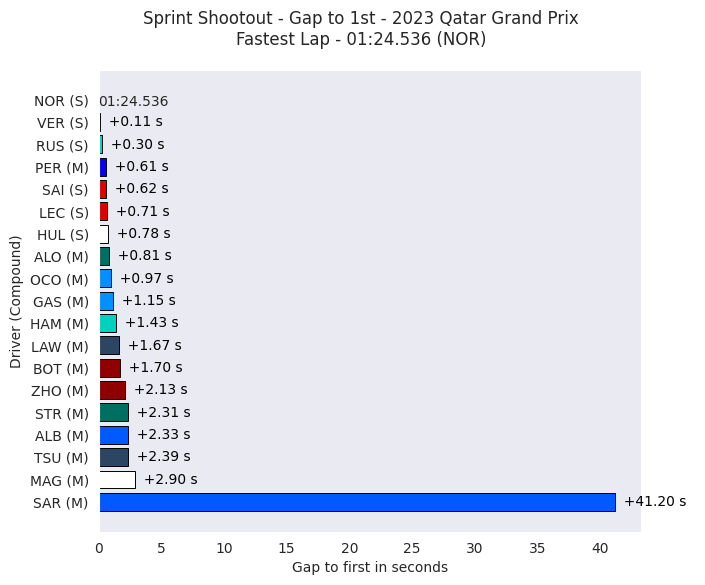

In [ ]:
# Plot all the data
fig, ax = plt.subplots(figsize=(7, 6))

ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'], color=team_colors, linewidth=0.7, edgecolor='black')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels([f"{driver} ({compound[0]})" for driver, compound in zip(fastest_laps['Driver'], fastest_laps['Compound'])])
ax.set_xlabel("Gap to first in seconds")
ax.set_ylabel("Driver (Compound)")
ax.invert_yaxis()

# Value of each column (Gap to 1st)
for index, value in enumerate(fastest_laps['LapTimeDelta']):
    if index == 0:
        continue
    ax.text(value, index, f"  +{value:.2f} s  ", va='center', fontsize=10, color='black')

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')
plt.suptitle(f"{session.name} - Gap to 1st - {session.event.year} {session.event.EventName}\n"
             f"Fastest Lap - {lap_time_string} ({pole_lap['Driver']})")

ax.annotate(lap_time_string, xy=(0, 0), xytext=(0, 0.25))  #First (time) column

plt.grid(False)
plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/session_gap_first.png", bbox_inches='tight', dpi=500)
plt.show()

# Fastest Drivers in Each Sector

https://github.com/edmundhong/formula1-dataanalysis/blob/main/Best%20Lap%20Analysis.ipynb

In [ ]:
# Load laps
df = session.laps

# Convert Times to seconds
df.LapTime = df.LapTime.dt.total_seconds()
df.Sector1Time = df.Sector1Time.dt.total_seconds()
df.Sector2Time = df.Sector2Time.dt.total_seconds()
df.Sector3Time = df.Sector3Time.dt.total_seconds()

In [ ]:
# Get Quali results
df_results = session.results

driver_color = {}
for index,row in df_results.iterrows():
    driver = row['Abbreviation']
    driver_color[driver] = ff1.plotting.driver_color(driver)

# Get the top 10 fastest SectorTime
top_10_sector1 = df.groupby(['Driver'])['Sector1Time'].min().sort_values().head(10).reset_index()
top_10_sector2 = df.groupby(['Driver'])['Sector2Time'].min().sort_values().head(10).reset_index()
top_10_sector3 = df.groupby(['Driver'])['Sector3Time'].min().sort_values().head(10).reset_index()

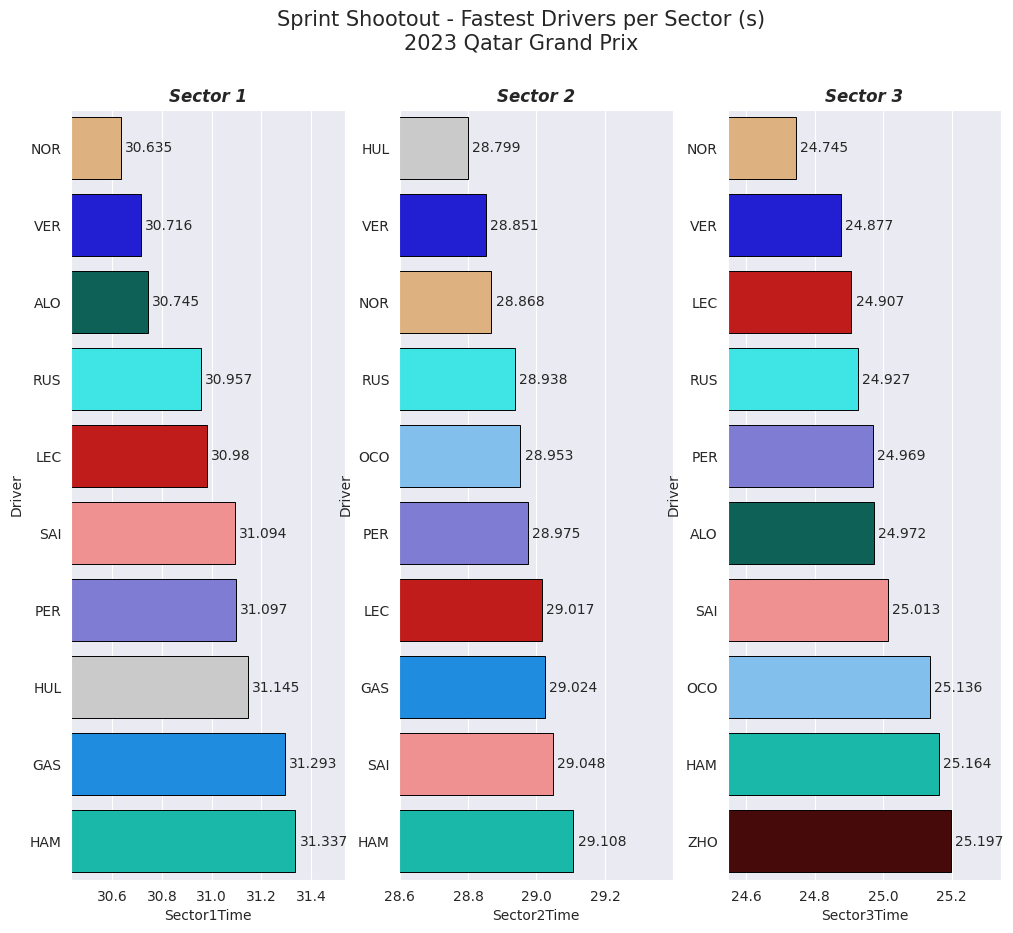

In [ ]:
# Plot
fig, ax = plt.subplots(1,3, figsize=(12, 10))
fig.suptitle(f"{session.name} - Fastest Drivers per Sector (s)\n{session.event.year} {session.event.EventName}", fontsize=15)

# Sector 1
sns.barplot(x=top_10_sector1['Sector1Time'], y=top_10_sector1['Driver'], palette=driver_color, ax=ax[0], edgecolor='black', lw=0.7)
ax[0].set_title('Sector 1', fontweight="bold", fontstyle='italic')
ax[0].bar_label(ax[0].containers[0], padding=3)
ax[0].set_xlim(top_10_sector1.Sector1Time[0]-0.2,top_10_sector1.Sector1Time[0]+0.9)    # Cambiar segun diff, por estético

# Sector 2
sns.barplot(x=top_10_sector2['Sector2Time'], y=top_10_sector2['Driver'], palette=driver_color, ax=ax[1], edgecolor='black', lw=0.7)
ax[1].set_title('Sector 2', fontweight="bold", fontstyle='italic')
ax[1].bar_label(ax[1].containers[0], padding=3)
ax[1].set_xlim(top_10_sector2.Sector2Time[0]-0.2,top_10_sector2.Sector2Time[0]+0.6)

# Sector 3
sns.barplot(x=top_10_sector3['Sector3Time'], y=top_10_sector3['Driver'], palette=driver_color, ax=ax[2], edgecolor='black', lw=0.7)
ax[2].set_title('Sector 3', fontweight="bold", fontstyle='italic')
ax[2].bar_label(ax[2].containers[0], padding=3)
ax[2].set_xlim(top_10_sector3.Sector3Time[0]-0.2,top_10_sector3.Sector3Time[0]+0.6)

plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/quali_fastest_sectors.png", bbox_inches='tight', dpi=500)
plt.show()

# Max and Min Speed of Each Team in Fastest Lap

In [ ]:
# Speeds
team_max_speed = {}
team_min_speed = {}

for team in set(df.Team):
    team_max_speed[team] = df.pick_team(team).pick_fastest().get_car_data().Speed.max()
    team_min_speed[team] = df.pick_team(team).pick_fastest().get_car_data().Speed.min()

team_max_speed = pd.DataFrame(team_max_speed.items(), columns=['Team', 'Max Speed']).sort_values('Max Speed', ascending=False).reset_index()
team_min_speed = pd.DataFrame(team_min_speed.items(), columns=['Team', 'Min Speed']).sort_values('Min Speed', ascending=False).reset_index()


team_color = {}
for team in team_max_speed.Team:
    team_color[team] = ff1.plotting.team_color(team)

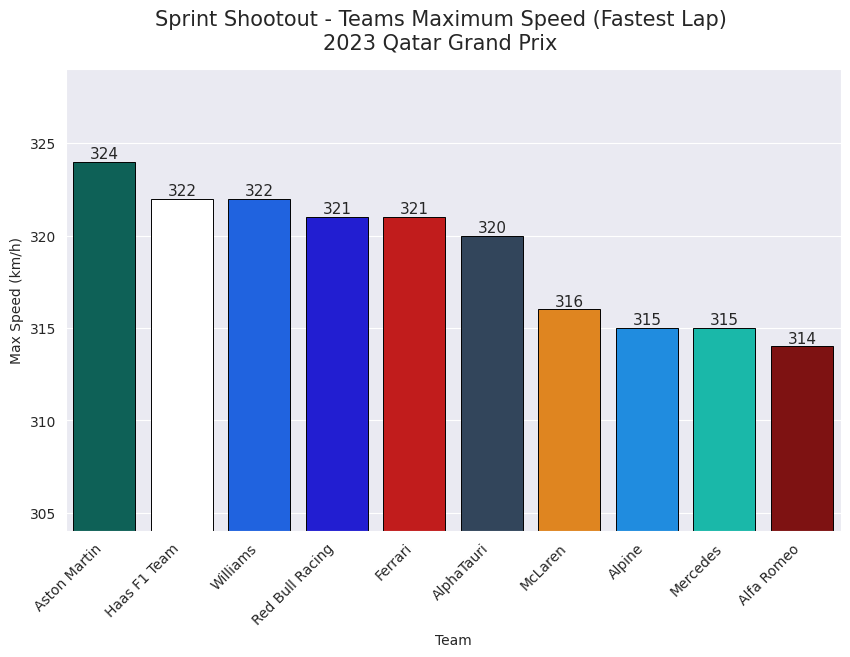

In [ ]:
# Plot max
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle(f"{session.name} - Teams Maximum Speed (Fastest Lap)\n{session.event.year} {session.event.EventName}", fontsize=15)

# Max Speed
sns.barplot(data=team_max_speed, x='Team', y='Max Speed' , palette=team_color, ax=ax, edgecolor='black', lw=0.7)
ax.set_ylim(team_max_speed['Max Speed'].min()-10, team_max_speed['Max Speed'].max()+5)    # Cambiar hasta que mole representación
plt.xticks(rotation=45, ha='right')

# Add speed
for i in range(len(team_max_speed)):
    ax.text(i, team_max_speed['Max Speed'][i]+0.2, team_max_speed['Max Speed'][i], ha = 'center', size = 11)

plt.ylabel('Max Speed (km/h)')
plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/max_speed.png", bbox_inches='tight', dpi=500)
plt.show()

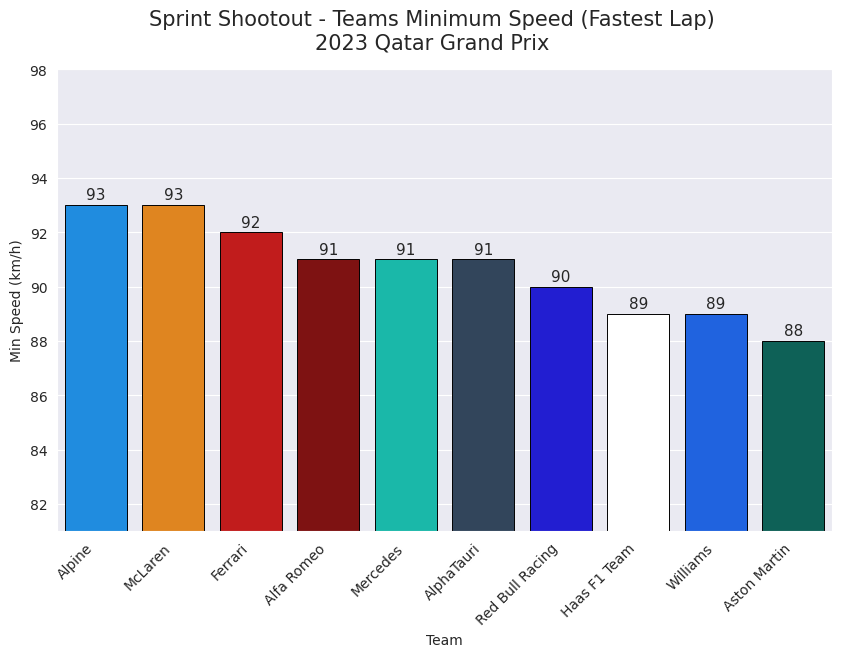

In [ ]:
# Plot min
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle(f"{session.name} - Teams Minimum Speed (Fastest Lap)\n{session.event.year} {session.event.EventName}", fontsize=15)

# Min Speed
sns.barplot(data=team_min_speed, x='Team', y='Min Speed' , palette=team_color, ax=ax, edgecolor='black', lw=0.7)
ax.set_ylim(team_min_speed['Min Speed'].min()-7, team_min_speed['Min Speed'].max()+5)
plt.xticks(rotation=45, ha='right')

# Add speed
for i in range(len(team_min_speed)):
    ax.text(i, team_min_speed['Min Speed'][i]+0.2, team_min_speed['Min Speed'][i], ha = 'center', size = 11)

plt.ylabel('Min Speed (km/h)')
plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/min_speed.png", bbox_inches='tight', dpi=500)
plt.show()

# Minisectors dominance 2 drivers

In [ ]:
# Setup plotting (reset plot settings, now dark background)
plotting.setup_mpl()

# Load again (if not, errors)
session.load()

In [ ]:
laps = session.laps
results = session.results

# Drivers
driver1 = 'NOR'
driver2 = 'VER'

# Get drivers lap > fastest > telemetry data (.get_car_data doesn't work, we need the 'X' and 'Y' columns from .get_telemetry)
fastest_lap_driver1 = laps.pick_driver(driver1).pick_fastest()
fastest_lap_driver2 = laps.pick_driver(driver2).pick_fastest()

telemetry_lap_driver1 = fastest_lap_driver1.get_telemetry().add_distance()
telemetry_lap_driver2 = fastest_lap_driver2.get_telemetry().add_distance()

# Fastest laptime of each driver
fastest_time1 = strftimedelta(fastest_lap_driver1['LapTime'], '%m:%s.%ms')
fastest_time2 = strftimedelta(fastest_lap_driver2['LapTime'], '%m:%s.%ms')

# New column that indicates the driver
telemetry_lap_driver1['Driver'] = driver1
telemetry_lap_driver2['Driver'] = driver2

# Merge telemetries
telemetry = telemetry_lap_driver1.append(telemetry_lap_driver2)

<ipython-input-25-d86f108d7d34>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry_lap_driver1.append(telemetry_lap_driver2)


In [ ]:
'''# Colors
driver_color = {}
for index,row in results.iterrows():
    driver = row['Abbreviation']
    driver_color[driver] = ff1.plotting.driver_color(driver)   # driver1: '#0600ef' ....'''

driver1_color = ff1.plotting.driver_color(driver1)
driver2_color = ff1.plotting.driver_color(driver2)

**Defining minisectors**

In [ ]:
# Creating minisectors (can change): assign every row a minisector depending on the current distance
num_minisectors = 25
total_distance = max(telemetry['Distance'])
minisector_length = total_distance / num_minisectors
telemetry['Minisector'] = (telemetry['Distance'] // minisector_length + 1)

***3º: Plotting***

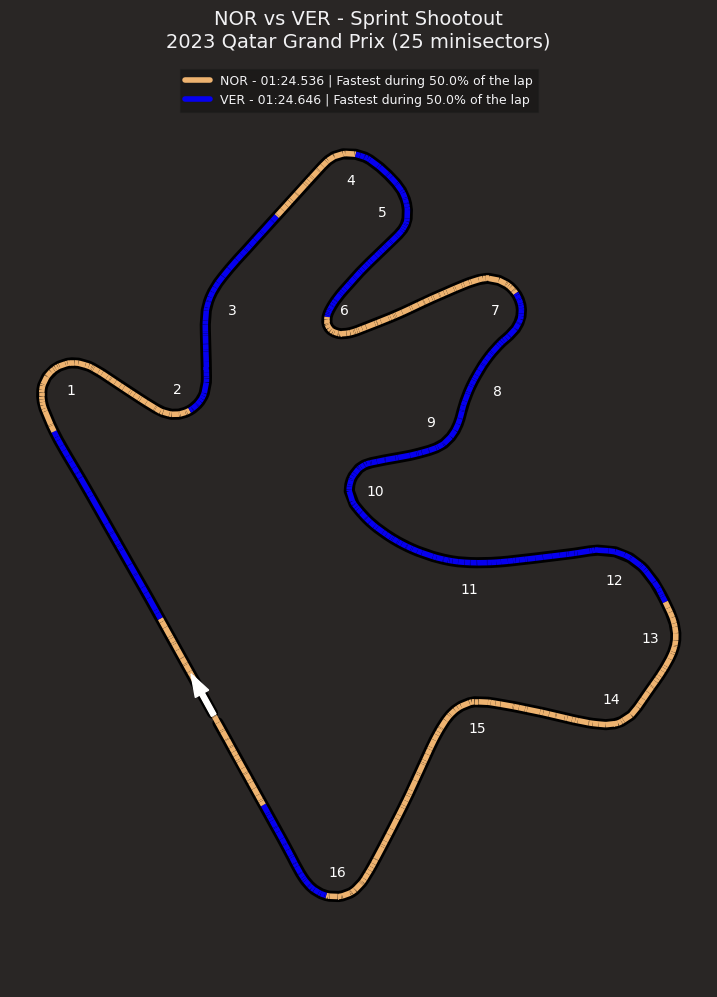

In [ ]:
# Track Dominance
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()  # New DF: we calculate avg. speed per driver per minisector
best_sectors = average_speed.groupby(['Minisector'])['Speed'].max().reset_index()
best_sectors = best_sectors.merge(average_speed[['Speed','Driver']], on=['Speed']).rename(columns={'Driver':'FastestSectorDriver', 'Speed':'FastestSectorSpeed'})
track_dominance = best_sectors.FastestSectorDriver.value_counts(normalize=True)
best_sectors = best_sectors.merge(telemetry, on=['Minisector'])                            # Combine 2 DF: telemetry (main) with fastest_driver per minisector (based on minisector column, every minisector repeated, = driver)

# Get Fastest Driver of each minisector
best_sectors['FastestSectorDriver'] = best_sectors['FastestSectorDriver'].map({driver1:1,driver2:2})
map_sectors = best_sectors.loc[best_sectors['Driver'] == driver1]

'''============'''
        # For plotting the DOMINANCE line:
# Where the car is at any moment in time ('x' n 'y' are columns in telemetry)
single_lap = telemetry.loc[telemetry['Driver'] == driver1]
lap_x = np.array(single_lap['X'].values)
lap_y = np.array(single_lap['Y'].values)

# Create points, and with them, segment (draw shape)
points = np.array([lap_x, lap_y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Coloring the plot (according to the fastest driver and their colors)
colors = [driver1_color, driver2_color]
cmap = ListedColormap(colors)
line_comp = LineCollection(segments, norm = plt.Normalize(1, cmap.N), cmap = cmap, linewidth=4)
line_comp.set_array(map_sectors['FastestSectorDriver'])

'''============'''
# For plotting the BLACK line:
laps = session.laps.pick_fastest()
pos = laps.get_pos_data()
circuit_info = session.get_circuit_info()

# By matrix multiplication of the rotation matrix with a vector [x, y], a new rotated vector [x_rot, y_rot] is obtained.
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

# Get the coordinates: an array of shape [n, 2] where n is the number of points and the second axis is x and y
track = pos.loc[:, ('X', 'Y')].to_numpy()

'''============'''
# PLOT
plt.figure(figsize=(9, 12))
plt.title(f'{driver1} vs {driver2} - {session.name}\n'
          f'{session.event.year} {session.event.EventName} ({num_minisectors} minisectors)', size=14)

# Add a solid black line around the circuit
plt.plot(track[:, 0], track[:, 1], color='black', linewidth=8)

# Add the collection of lines (dominance) to represent the circuit
plt.gca().add_collection(line_comp)

'''============'''
# CORNERS
# 1-Length of the space between number and track
offset_vector = [500, 0]

# 2-Iterate over all corners
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Finally, PRINT THE CORNER NUMBER.
    plt.text(text_x, text_y, txt, va='center_baseline', ha='center', size='medium', color='white')

'''============'''
# Some settings
plt.arrow(lap_x[0], lap_y[0], lap_x[5]-lap_x[0], lap_y[5]-lap_y[0], width=100, color='white', zorder=100)
plt.axis('equal')
plt.axis('off')

# Legend
legend_color = [
    Line2D([0], [0], color=driver1_color, lw = 4),
    Line2D([0], [0], color=driver2_color, lw = 4)]

plt.legend(legend_color, [
            f"{driver1} - {fastest_time1} | Fastest during {round(track_dominance[driver1]*100,1)}% of the lap",
            f"{driver2} - {fastest_time2} | Fastest during {round(track_dominance[driver2]*100,1)}% of the lap"],
            facecolor='black', framealpha=0.3, loc='upper center', fontsize=9)

plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/minisector_doble_dominance.png", bbox_inches='tight', dpi=500)

plt.show()

# Minisectors dominance 3 drivers

In [ ]:
laps = session.laps
results = session.results

# Drivers
driver1 = 'NOR'
driver2 = 'VER'
driver3 = 'ALO'

# Get drivers lap > fastest > telemetry data
fastest_lap_driver1 = laps.pick_driver(driver1).pick_fastest()
fastest_lap_driver2 = laps.pick_driver(driver2).pick_fastest()
fastest_lap_driver3 = laps.pick_driver(driver3).pick_fastest()

telemetry_lap_driver1 = fastest_lap_driver1.get_telemetry().add_distance()
telemetry_lap_driver2 = fastest_lap_driver2.get_telemetry().add_distance()
telemetry_lap_driver3 = fastest_lap_driver3.get_telemetry().add_distance()

# Fastest laptime of each driver
fastest_time1 = strftimedelta(fastest_lap_driver1['LapTime'], '%m:%s.%ms')
fastest_time2 = strftimedelta(fastest_lap_driver2['LapTime'], '%m:%s.%ms')
fastest_time3 = strftimedelta(fastest_lap_driver3['LapTime'], '%m:%s.%ms')

# New column that indicates the driver
telemetry_lap_driver1['Driver'] = driver1
telemetry_lap_driver2['Driver'] = driver2
telemetry_lap_driver3['Driver'] = driver3

# Merge telemetries
telemetry = telemetry_lap_driver1.append(telemetry_lap_driver2)
telemetry = telemetry.append(telemetry_lap_driver3)

<ipython-input-41-4a2970096cae>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry_lap_driver1.append(telemetry_lap_driver2)
<ipython-input-41-4a2970096cae>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(telemetry_lap_driver3)


In [ ]:
'''# Colors
driver_color = {}
for index,row in results.iterrows():
    driver = row['Abbreviation']
    driver_color[driver] = ff1.plotting.driver_color(driver)   # driver1: '#0600ef' ....'''

driver1_color = ff1.plotting.driver_color(driver1)
driver2_color = ff1.plotting.driver_color(driver2)
driver3_color = ff1.plotting.driver_color(driver3)

In [ ]:
# Creating minisectors (can change): assign every row a minisector depending on the current distance
num_minisectors = 25
total_distance = max(telemetry['Distance'])
minisector_length = total_distance / num_minisectors
telemetry['Minisector'] = (telemetry['Distance'] // minisector_length + 1)

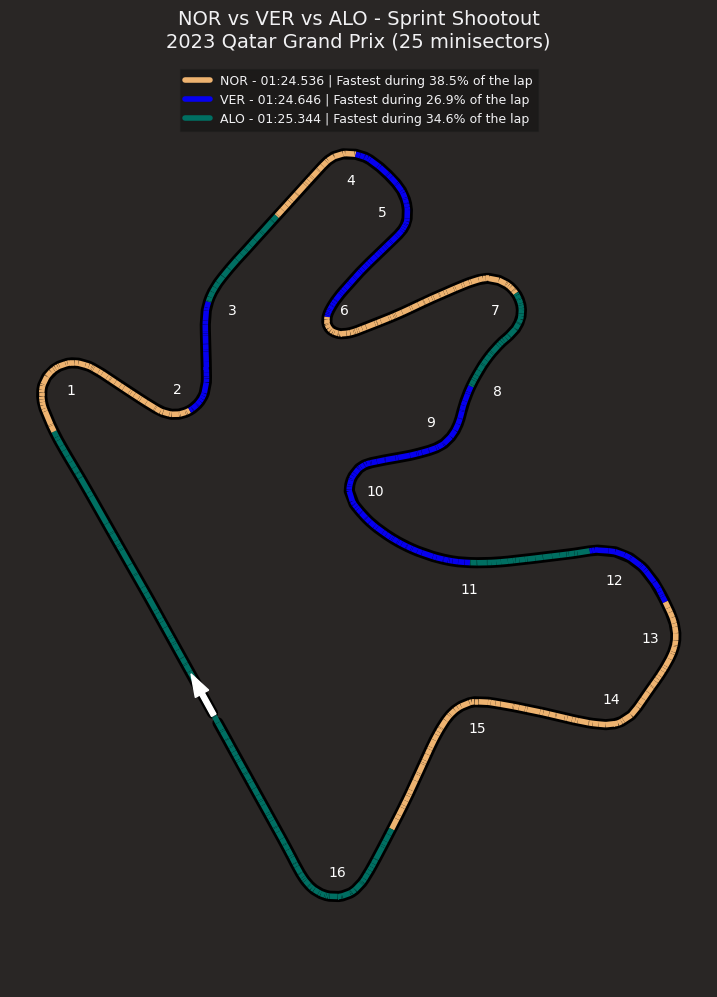

In [ ]:
# Track Dominance
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
best_sectors = average_speed.groupby(['Minisector'])['Speed'].max().reset_index()
best_sectors = best_sectors.merge(average_speed[['Speed','Driver']], on=['Speed']).rename(columns={'Driver':'FastestSectorDriver', 'Speed':'FastestSectorSpeed'})
track_dominance = best_sectors.FastestSectorDriver.value_counts(normalize=True)
best_sectors = best_sectors.merge(telemetry, on=['Minisector'])

# Get Fastest Driver of each minisector
best_sectors['FastestSectorDriver'] = best_sectors['FastestSectorDriver'].map({driver1:1,driver2:2,driver3:3})
map_sectors = best_sectors.loc[best_sectors['Driver'] == driver1]

'''============'''
        # For plotting the DOMINANCE line:
# Where the car is at any moment in time ('x' n 'y' are columns in telemetry)
single_lap = telemetry.loc[telemetry['Driver'] == driver1]
lap_x = np.array(single_lap['X'].values)
lap_y = np.array(single_lap['Y'].values)

# Create points, and with them, segment (draw shape)
points = np.array([lap_x, lap_y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Coloring the plot (according to the fastest driver and their colors), or just: ff1.plotting.driver_color(driver1/2/3)
colors = [driver1_color, driver2_color, driver3_color]
cmap = ListedColormap(colors)
line_comp = LineCollection(segments, norm = plt.Normalize(1, cmap.N), cmap = cmap, linewidth=4)
line_comp.set_array(map_sectors['FastestSectorDriver'])

'''============'''
# For plotting the BLACK line:
laps = session.laps.pick_fastest()
pos = laps.get_pos_data()
circuit_info = session.get_circuit_info()

# By matrix multiplication of the rotation matrix with a vector [x, y], a new rotated vector [x_rot, y_rot] is obtained.
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

# Get the coordinates: an array of shape [n, 2] where n is the number of points and the second axis is x and y
track = pos.loc[:, ('X', 'Y')].to_numpy()

'''============'''
# PLOT
plt.figure(figsize=(9, 12))
plt.title(f'{driver1} vs {driver2} vs {driver3} - {session.name}\n'
          f'{session.event.year} {session.event.EventName} ({num_minisectors} minisectors)', size=14)

# Add a solid black line around the circuit
plt.plot(track[:, 0], track[:, 1], color='black', linewidth=8)

# Add the collection of lines (dominance) to represent the circuit
plt.gca().add_collection(line_comp)

'''============'''
# CORNERS
# 1-Length of the space between number and track
offset_vector = [500, 0]

# 2-Iterate over all corners
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Finally, PRINT THE CORNER NUMBER.
    plt.text(text_x, text_y, txt, va='center_baseline', ha='center', size='medium', color='white')

'''============'''
# Some settings
plt.arrow(lap_x[0], lap_y[0], lap_x[5]-lap_x[0], lap_y[5]-lap_y[0], width=100, color='white', zorder=100)
plt.axis('equal')
plt.axis('off')

# Legend
legend_color = [
    Line2D([0], [0], color=driver1_color, lw = 4),
    Line2D([0], [0], color=driver2_color, lw = 4),
    Line2D([0], [0], color=driver3_color, lw = 4)]

plt.legend(legend_color, [
            f"{driver1} - {fastest_time1} | Fastest during {round(track_dominance[driver1]*100,1)}% of the lap",
            f"{driver2} - {fastest_time2} | Fastest during {round(track_dominance[driver2]*100,1)}% of the lap",
            f"{driver3} - {fastest_time3} | Fastest during {round(track_dominance[driver3]*100,1)}% of the lap"],
            facecolor='black', framealpha=0.3, loc='upper center', fontsize=9)

plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/minisector_triple_dominance.png", bbox_inches='tight', dpi=500)

plt.show()

# Telemetry

**Time delta**

Use with caution: this delta is an estimation, and not too accurate. So, it doesn't represent the real gap during the whole lap, but it shows us where a driver gained or lost time compared to another (plotted together with 'speed').

In [ ]:
delta_time, ref_tel, compare_tel = utils.delta_time(fastest_lap_driver1, fastest_lap_driver2)

/usr/local/lib/python3.10/dist-packages/fastf1/utils.py:86: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


In [ ]:
# Load laps again
laps = session.laps

# QUALI: Get fastest Q lap telemetry
lap_telemetry_driver1 = laps.pick_driver(driver1).pick_fastest().get_car_data().add_distance()
lap_telemetry_driver2 = laps.pick_driver(driver2).pick_fastest().get_car_data().add_distance()

# Colors
driver1_color = ff1.plotting.driver_color(driver1)
driver2_color = ff1.plotting.driver_color(driver2)

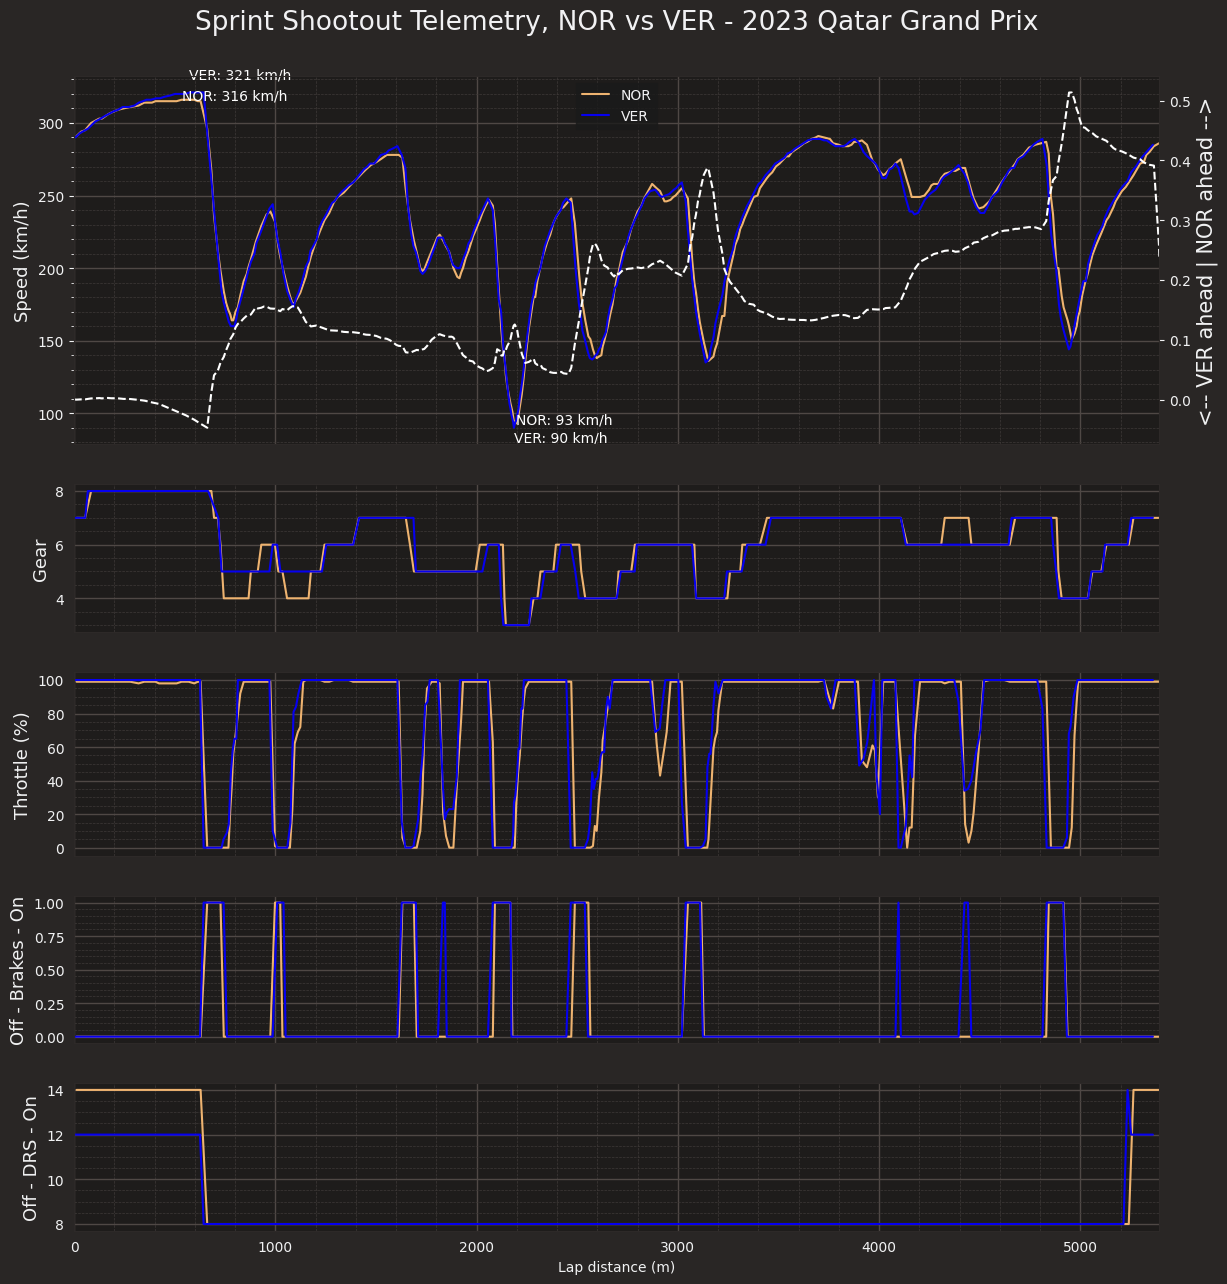

In [ ]:
# Create the plot
fig, ax = plt.subplots(5, figsize=(14,15), gridspec_kw={'height_ratios': [2, 0.8, 1, 0.8, 0.8]})

ax[0].title.set_text(f"{session.name} Telemetry, {driver1} vs {driver2} - {session.event.year} {session.event.EventName}\n")   # Here in [0], to be closer to the plot

# Speed
ax[0].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Speed'], label=driver1, color=driver1_color)
ax[0].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Speed'], label=driver2, color=driver2_color)
ax[0].set_ylabel('Speed (km/h)', fontsize=13)
ax[0].legend(loc="upper center")

# Delta
twin = ax[0].twinx()   # right scale
twin.plot(ref_tel['Distance'], delta_time, '--', color='white')
twin.set_ylabel(f"<-- {driver2} ahead | {driver1} ahead -->", size=15)

# Maximum and Minimum speed of drivers
driver1_max_speed = lap_telemetry_driver1['Speed'].max()
driver1_min_speed = lap_telemetry_driver1['Speed'].min()
driver2_max_speed = lap_telemetry_driver2['Speed'].max()
driver2_min_speed = lap_telemetry_driver2['Speed'].min()
ax[0].annotate(f'{driver1}: {driver1_max_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmax()], driver1_max_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')   #valores x,y | posición texto
ax[0].annotate(f'{driver1}: {driver1_min_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmin()], driver1_min_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')
ax[0].annotate(f'{driver2}: {driver2_max_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmax()], driver2_max_speed), textcoords="offset points", xytext=(0, 10), ha='left', color='white')
ax[0].annotate(f'{driver2}: {driver2_min_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmin()], driver2_min_speed), textcoords="offset points", xytext=(0, -10), ha='left', color='white')

# Gear
ax[1].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['nGear'], label=driver1, color=driver1_color)
ax[1].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['nGear'], label=driver2, color=driver2_color)
ax[1].set_ylabel('Gear', fontsize=13)

# Throttle
ax[2].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Throttle'], label=driver1, color=driver1_color)
ax[2].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Throttle'], label=driver2, color=driver2_color)
ax[2].set_ylabel('Throttle (%)', fontsize=13)

# Brake
ax[3].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Brake'], label=driver1, color=driver1_color)
ax[3].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Brake'], label=driver2, color=driver2_color)
ax[3].set_ylabel('Off - Brakes - On', fontsize=13)

# DRS
ax[4].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['DRS'], label=driver1, color=driver1_color)
ax[4].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['DRS'], label=driver2, color=driver2_color)
ax[4].set_ylabel('Off - DRS - On', fontsize=13)
ax[4].set(xlabel='Lap distance (m)')

# Hide axis labels on subplots that are not on the outer edges
for a in ax.flat:
    a.label_outer()

# No space in the sides
for i in range(5):
    ax[i].set_xlim(0, max(lap_telemetry_driver1['Distance']))

# Remove horizontal lines
plt.gca().yaxis.grid(False)

plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/full_telemetry.png", bbox_inches='tight', dpi=500)

plt.show()